In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def load_idx_images(filename):
    with open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    return data.reshape(-1, 28, 28)

def load_idx_labels(filename):
    with open(filename, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)
    return labels

x_train = load_idx_images('/kaggle/input/mnist-dataset/train-images.idx3-ubyte')
y_train = load_idx_labels('/kaggle/input/mnist-dataset/train-labels.idx1-ubyte')
x_test = load_idx_images('/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte')
y_test = load_idx_labels('/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte')

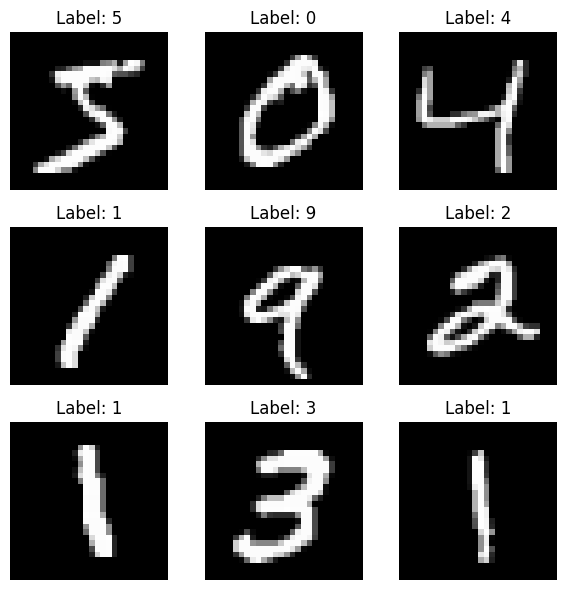

In [8]:
#visulaize the dataset
# Function to display a grid of images
def plot_sample_images(images, labels, num_samples=9):
    plt.figure(figsize=(6,6))
    for i in range(num_samples):
        plt.subplot(3, 3, i + 1)  # 3x3 grid
        plt.imshow(images[i], cmap='gray')  # Display the image
        plt.title(f"Label: {labels[i]}")  # Show label
        plt.axis("off")  # Hide axis
    plt.tight_layout()
    plt.show()

# Visualize sample images
plot_sample_images(x_train, y_train)

Create PyTorch Dataset class and Dataloaders 

In [15]:
# Normalize to [0, 1]
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

In [16]:
#Dataset class
from torch.utils.data import Dataset, DataLoader
class MNISTDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = torch.tensor(self.images[idx]).unsqueeze(0)  # Shape: [1, 28, 28]
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label


In [17]:
#Data loader 
train_dataset = MNISTDataset(x_train, y_train)
test_dataset  = MNISTDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [20]:
print("x_train shape:", x_train.shape)  # Should be (60000, 28, 28)
print("y_train shape:", y_train.shape)  # Should be (60000,)
print("x_test shape:", x_test.shape)    # Should be (10000, 28, 28)
print("y_test shape:", y_test.shape)    # Should be (10000,)


x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


In [19]:
#determines size 
len (train_dataset), len(test_dataset)

(60000, 10000)

In [21]:
#Print the shapes after batching 
# Check shape of one batch
for images, labels in train_loader:
    print("Batch images shape:", images.shape)  # [32, 1, 28, 28]
    print("Batch labels shape:", labels.shape)  # [32]
    break


Batch images shape: torch.Size([32, 1, 28, 28])
Batch labels shape: torch.Size([32])


In [22]:
import torch.nn as nn
import torch.nn.functional as F

class ANNModel(nn.Module):
    def __init__(self):
        super(ANNModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)  # Input to first hidden layer
        self.fc2 = nn.Linear(128, 64)       # First hidden to second hidden
        self.out = nn.Linear(64, 10)        # Second hidden to output

    def forward(self, x):
        x = self.flatten(x)         # Flatten the 28x28 image
        x = F.relu(self.fc1(x))     # ReLU on first hidden layer
        x = F.relu(self.fc2(x))     # ReLU on second hidden layer
        x = self.out(x)             # Raw logits (CrossEntropyLoss applies Softmax)
        return x


#model Summary 

In [23]:
!pip install torchinfo


In [24]:
from torchinfo import summary

model = ANNModel().to(device)
summary(model, input_size=(32, 1, 28, 28))  # (batch_size, channels, height, width)


Layer (type:depth-idx)                   Output Shape              Param #
ANNModel                                 [32, 10]                  --
├─Flatten: 1-1                           [32, 784]                 --
├─Linear: 1-2                            [32, 128]                 100,480
├─Linear: 1-3                            [32, 64]                  8,256
├─Linear: 1-4                            [32, 10]                  650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 3.50
Input size (MB): 0.10
Forward/backward pass size (MB): 0.05
Params size (MB): 0.44
Estimated Total Size (MB): 0.59

In [27]:
#initialize components 
from torchmetrics.classification import Accuracy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ANNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Accuracy metric (will be used in both train and val loops)
train_accuracy = Accuracy(task="multiclass", num_classes=10).to(device)
val_accuracy = Accuracy(task="multiclass", num_classes=10).to(device)


In [28]:

import torch.optim as optim
from torchmetrics.classification import Accuracy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ANNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# TorchMetrics
train_accuracy = Accuracy(task="multiclass", num_classes=10).to(device)
val_accuracy = Accuracy(task="multiclass", num_classes=10).to(device)

# Intialize Arrays to Store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 10

for epoch in range(num_epochs):
    # ---------- Training ----------
    model.train()
    running_loss = 0.0
    train_accuracy.reset()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        train_accuracy.update(outputs, labels)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = train_accuracy.compute().item()
    
    # ---------- Validation ----------
    model.eval()
    val_running_loss = 0.0
    val_accuracy.reset()

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            val_accuracy.update(outputs, labels)

    epoch_val_loss = val_running_loss / len(test_loader.dataset)
    epoch_val_acc = val_accuracy.compute().item()

    # ---------- Store metrics ----------
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_accuracies.append(epoch_train_acc)
    val_accuracies.append(epoch_val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")


Epoch 1/10 | Train Loss: 0.2916 | Train Acc: 0.9154 | Val Loss: 0.1380 | Val Acc: 0.9576
Epoch 2/10 | Train Loss: 0.1223 | Train Acc: 0.9630 | Val Loss: 0.1025 | Val Acc: 0.9698
Epoch 3/10 | Train Loss: 0.0843 | Train Acc: 0.9737 | Val Loss: 0.0845 | Val Acc: 0.9738
Epoch 4/10 | Train Loss: 0.0639 | Train Acc: 0.9795 | Val Loss: 0.0839 | Val Acc: 0.9737
Epoch 5/10 | Train Loss: 0.0499 | Train Acc: 0.9838 | Val Loss: 0.0918 | Val Acc: 0.9736
Epoch 6/10 | Train Loss: 0.0402 | Train Acc: 0.9866 | Val Loss: 0.0848 | Val Acc: 0.9757
Epoch 7/10 | Train Loss: 0.0328 | Train Acc: 0.9891 | Val Loss: 0.1049 | Val Acc: 0.9703
Epoch 8/10 | Train Loss: 0.0296 | Train Acc: 0.9899 | Val Loss: 0.0753 | Val Acc: 0.9791
Epoch 9/10 | Train Loss: 0.0224 | Train Acc: 0.9927 | Val Loss: 0.0921 | Val Acc: 0.9772
Epoch 10/10 | Train Loss: 0.0210 | Train Acc: 0.9928 | Val Loss: 0.0910 | Val Acc: 0.9783


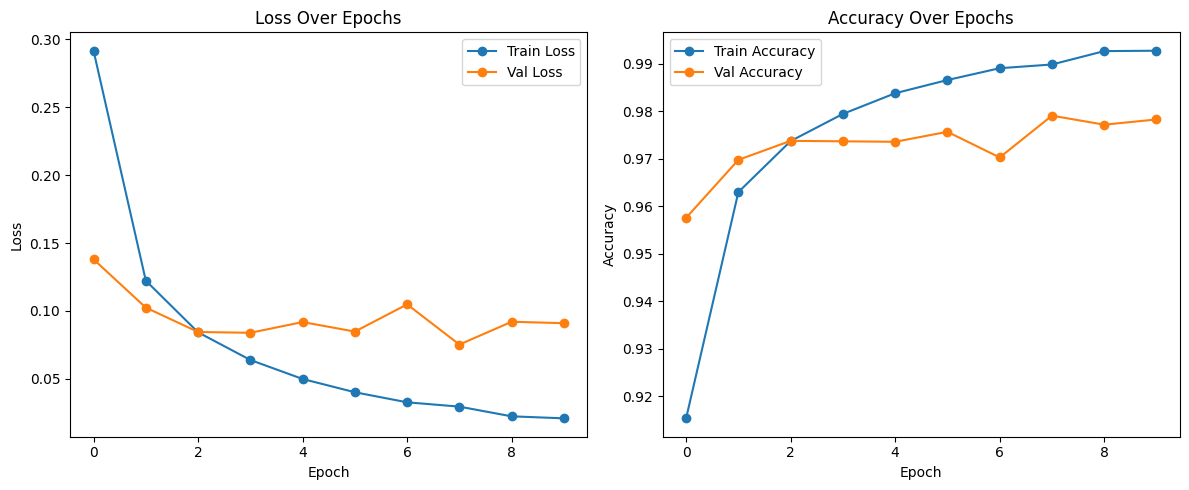

In [29]:
# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Val Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [30]:
from torchmetrics.classification import Accuracy

# Initialize loss function and accuracy metric
criterion = nn.CrossEntropyLoss()
test_accuracy = Accuracy(task="multiclass", num_classes=10).to(device)

# Evaluation loop
model.eval()
test_loss = 0.0
test_accuracy.reset()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)  # total loss

        test_accuracy.update(outputs, labels)

# Final metrics
avg_test_loss = test_loss / len(test_loader.dataset)
final_test_acc = test_accuracy.compute().item()

print(f"\nTest Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {final_test_acc:.4f}")



Test Loss: 0.0910
Test Accuracy: 0.9783
